In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from modules import lee_filter,filter_by_tide_height,load_s1_by_orbits
from skimage.filters import threshold_minimum, threshold_otsu
from deafrica_tools.spatial import xr_rasterize
from datacube.utils.geometry import Geometry

## Annual shorelines produced from Landsat

In [2]:
%%time
year=2018
shoreline_annual = gpd.read_file("https://deafrica-services.s3.af-south-1.amazonaws.com/coastlines/v0.4.0/deafricacoastlines_v0.4.0.gpkg", 
                           layer="shorelines_annual").query(f"year=={year}")
shoreline_annual.head()

CPU times: user 2min 35s, sys: 4 s, total: 2min 39s
Wall time: 5min 58s


,year,certainty,tide_datum,country,geometry
24,2018,good,0 m AMSL,Egypt,"MULTILINESTRING ((3340563.939 3519970.019, 334..."
25,2018,unstable data,0 m AMSL,Egypt,"MULTILINESTRING ((3340771.236 3530027.366, 334..."
55,2018,good,0 m AMSL,Egypt,"MULTILINESTRING ((3324663.374 3484072.311, 332..."
56,2018,unstable data,0 m AMSL,Egypt,"MULTILINESTRING ((3330692.815 3497345.905, 333..."
82,2018,good,0 m AMSL,NaN,None


In [3]:
coastal_grid_path="https://deafrica-input-datasets.s3.af-south-1.amazonaws.com/deafrica-coastlines/32km_coastal_grid_deafrica.geojson"
# Albers grid cells used to process the analysis
gridcell_gdf = gpd.read_file(coastal_grid_path).to_crs(epsg=6933).set_index('id')
gridcell_gdf.index=gridcell_gdf.index.astype(int)
gridcell_gdf.sort_values('id',inplace=True)
gridcell_gdf.head()

,left,top,right,bottom,geometry
id,,,,,
1,-2.479008e+06,2.157329e+06,-2.447008e+06,2.125329e+06,"MULTIPOLYGON (((-2474483.867 2125329.003, -247..."
2,-2.447008e+06,2.189329e+06,-2.415008e+06,2.157329e+06,"MULTIPOLYGON (((-2447008.208 2185622.468, -243..."
3,-2.447008e+06,2.157329e+06,-2.415008e+06,2.125329e+06,"MULTIPOLYGON (((-2447008.208 2157329.003, -241..."
4,-2.447008e+06,2.125329e+06,-2.415008e+06,2.093329e+06,"MULTIPOLYGON (((-2441834.147 2093329.003, -244..."
5,-2.415008e+06,2.189329e+06,-2.383008e+06,2.157329e+06,"MULTIPOLYGON (((-2402184.251 2189329.003, -239..."


In [4]:
# index=gridcell_gdf.index[0]
# index=43
index=645
# for index in gridcell_gdf.index:
gdf = gridcell_gdf.loc[[index]]
# Create query based on analysis gridcell extent
geopoly = Geometry(gdf.iloc[0].geometry, crs=gridcell_gdf.crs).buffer(0.001)

In [5]:
clipped_shoreline=gpd.clip(shoreline_annual,gdf.iloc[[0]])
clipped_shoreline

,year,certainty,tide_datum,country,geometry
49004,2018,unstable data,0 m AMSL,Namibia,"MULTILINESTRING ((1230682.676 -2437698.028, 12..."
49003,2018,good,0 m AMSL,Namibia,"MULTILINESTRING ((1224900.608 -2418677.869, 12..."
48969,2018,good,0 m AMSL,Namibia,"LINESTRING (1224898.706 -2418670.993, 1224900...."


In [6]:
clipped_shoreline['geometry']=clipped_shoreline['geometry'].buffer(200)
clipped_shoreline

,year,certainty,tide_datum,country,geometry
49004,2018,unstable data,0 m AMSL,Namibia,"POLYGON ((1230540.647 -2437839.763, 1230530.19..."
49003,2018,good,0 m AMSL,Namibia,"POLYGON ((1224704.933 -2418718.206, 1224703.54..."
48969,2018,good,0 m AMSL,Namibia,"POLYGON ((1225093.370 -2418624.552, 1225097.66..."


In [7]:
dc = datacube.Datacube(app="buffer coastlines")
query = {
    'geopolygon': geopoly,
    'time': (year),
    'dask_chunks': {'time': 1},
    'measurements': ['vh','mask'], # loading vv for experiement
    'resolution': (-20, 20),
    'output_crs':"EPSG:6933",
    'group_by':'solar_day',
}
# load s1 by orbit
S1=load_s1_by_orbits(dc,query)
coastal_mask = xr_rasterize(gdf=clipped_shoreline,
                                da=S1.vh,
                                transform=S1.vh.geobox.transform,
                                crs=S1.vh.geobox.crs)


Querying and loading Sentinel-1 ascending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 31 time steps as a dask array

Querying and loading Sentinel-1 descending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc


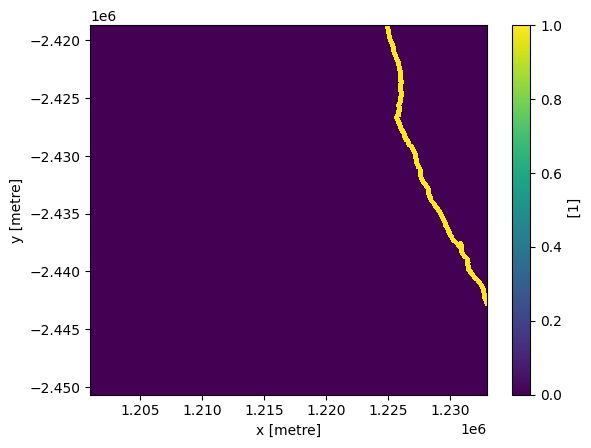

In [8]:
coastal_mask.plot.imshow()

In [9]:
from modules import filter_obs_by_orbit,filter_by_tide_height
# whether to apply orbit filtering
s1_orbit_filtering=True

In [10]:
# per-pixel tide modelling and filtering
print('Tide modelling and filtering for Sentinel-1...')
S1_filtered=filter_by_tide_height(S1,tide_centre=0.0)
# filter s1 observations by orbit if required
if s1_orbit_filtering:
    S1_filtered=filter_obs_by_orbit(S1_filtered)
# Scale to plot data in decibels
S1_filtered['vh'] = 10 * np.log10(S1_filtered.vh)

Tide modelling and filtering for Sentinel-1...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 31/31 [00:01<00:00, 15.70it/s]



Filtering Sentinel-1 product by orbit...


In [11]:
time_step='1Y'
# annual composites
print('Generate temporal composites...')
# median
ds_summaries_s1 = (S1_filtered[['vh']]
                     .resample(time=time_step)
                     .median('time')
                     .compute()
                    )

Generate temporal composites...


In [12]:
S1_filtered

<xarray.Dataset>
Dimensions:      (time: 12, y: 1600, x: 1600)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-25T17:37:28.075654 ... 2018-12...
  * y            (y) float64 -2.419e+06 -2.419e+06 ... -2.451e+06 -2.451e+06
  * x            (x) float64 1.201e+06 1.201e+06 ... 1.233e+06 1.233e+06
    spatial_ref  int32 6933
Data variables:
    vh           (time, y, x) float32 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    mask         (time, y, x) float64 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    tide_m       (time, y, x) float32 dask.array<chunksize=(12, 1600, 1600), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

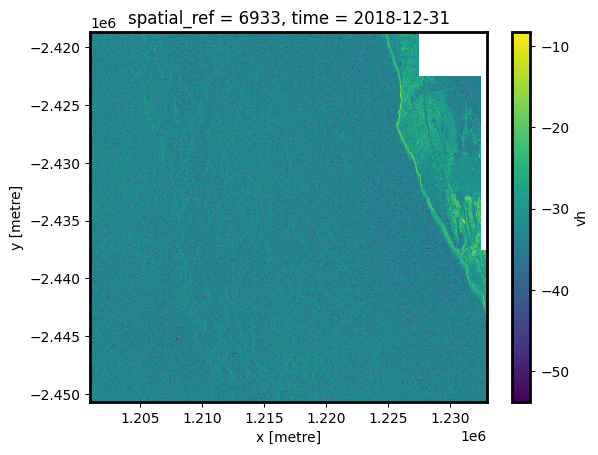

In [13]:
ds_summaries_s1.isel(time=0).vh.plot.imshow()

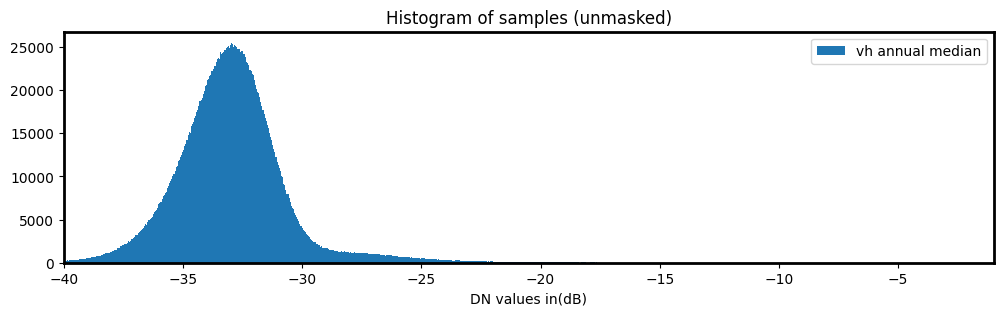

In [14]:
fig = plt.figure(figsize=(12, 3))
ds_summaries_s1.vh.plot.hist(bins=1000, label="vh annual median")
plt.xlim(-40,-1)
plt.legend()
plt.xlabel("DN values in(dB)")
plt.title("Histogram of samples (unmasked)");

In [15]:
threshold_m = threshold_minimum(ds_summaries_s1.vh.values[np.isfinite(ds_summaries_s1.vh.values)])
threshold_m

-51.029274

In [16]:
threshold_o = threshold_otsu(ds_summaries_s1.vh.values[np.isfinite(ds_summaries_s1.vh.values)])
threshold_o

-32.89028

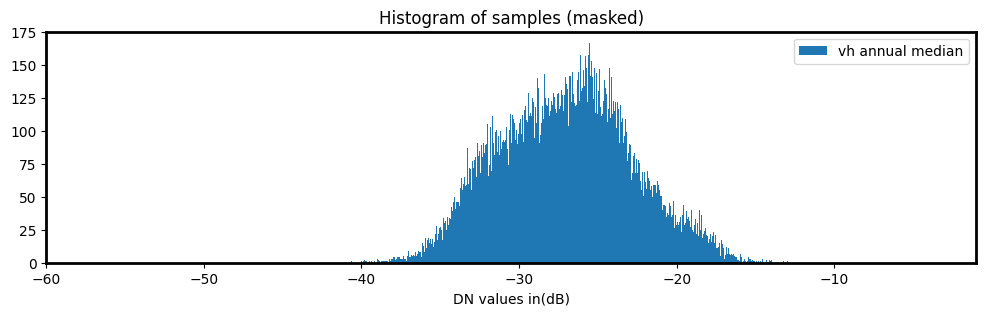

In [21]:
fig = plt.figure(figsize=(12, 3))
(ds_summaries_s1.vh.where(coastal_mask)).plot.hist(bins=500, label="vh annual median")
plt.xlim(-60,-1)
plt.legend()
plt.xlabel("DN values in(dB)")
plt.title("Histogram of samples (masked)");

In [20]:
ds_summaries_s1_masked=ds_summaries_s1.where(coastal_mask)
threshold_o_masked = threshold_otsu(ds_summaries_s1_masked.vh.values[np.isfinite(ds_summaries_s1_masked.vh.values)])
threshold_o_masked

-27.166107